#### Import libraries and packages

In [1]:
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.utils import column_or_1d

warnings.filterwarnings('ignore')

#### Import dataset

In [2]:
df = pd.read_csv("C:\\Users\\DNV\\OneDrive\\Desktop\\Data-Gold.csv",parse_dates=True,index_col=0)

#### Create a new Timestamp column for time series forecasting

In [3]:
df['Timestamp'] = pd.to_datetime(df.index).astype(np.int64) / 10**9
df_index = df.index
df_open = df['VND'].values.reshape(-1, 1)
df.head()

,VND,Timestamp
Date,,
2012-01-02,32202288.50,1.325462e+09
2012-01-03,33607538.00,1.325549e+09
2012-01-04,33923003.00,1.325635e+09
2012-01-05,33628569.00,1.325722e+09
2012-01-06,34000652.75,1.325808e+09


#### Plotting Gold price chart

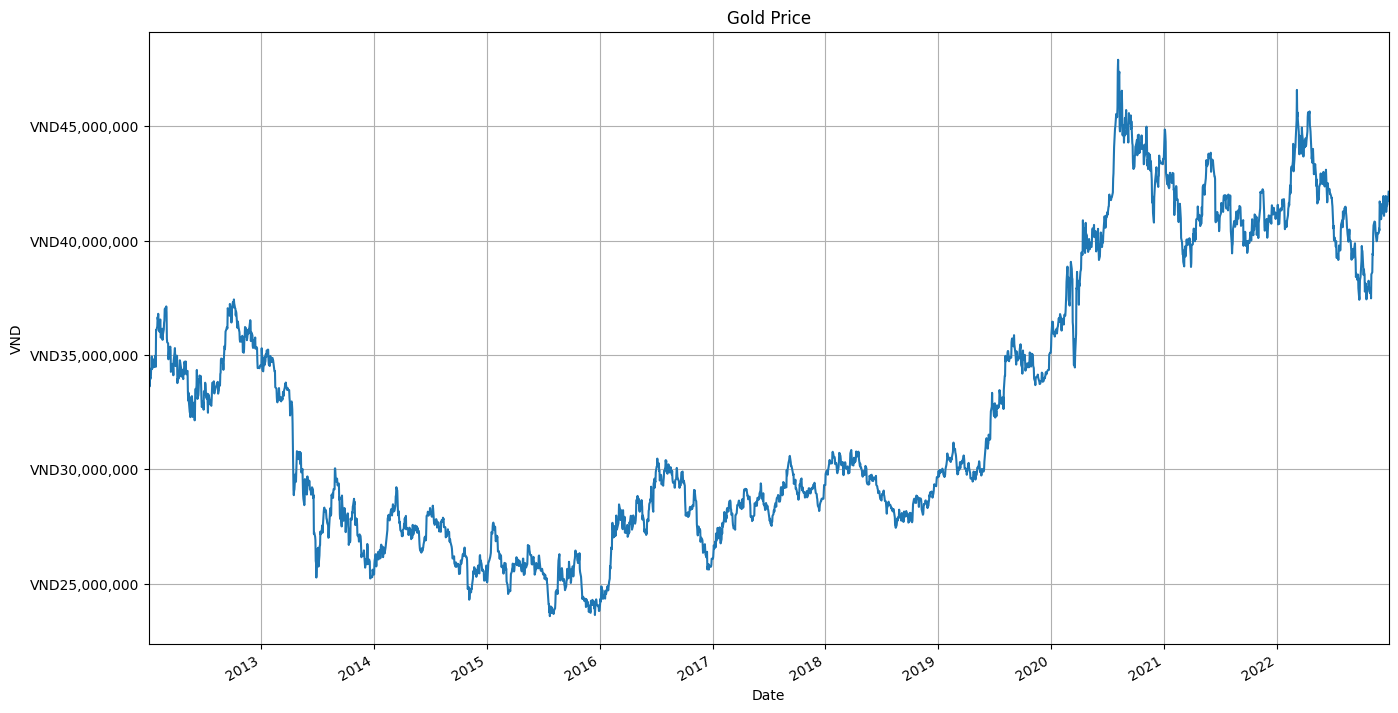

In [4]:
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('VND{x:,.0f}')

title = 'Gold Price'
ylabel = 'VND'
xlabel = 'Date'

ax = df['VND'].plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

#### Normalizing / scaling data to facilitate model building

In [5]:
LR_sc = StandardScaler()

df_scaled = df.copy()
df_scaled['VND'] = LR_sc.fit_transform(df_open)
df_scaled

,VND,Timestamp
Date,,
2012-01-02,-0.062575,1.325462e+09
2012-01-03,0.167826,1.325549e+09
2012-01-04,0.219549,1.325635e+09
2012-01-05,0.171274,1.325722e+09
2012-01-06,0.232280,1.325808e+09
...,...,...
2022-12-26,1.476100,1.672013e+09
2022-12-27,1.526588,1.672099e+09
2022-12-28,1.499084,1.672186e+09


In [6]:
X_sc = StandardScaler()
y_sc = StandardScaler()

X = df.iloc[:, 1].values.reshape(-1, 1)
y = df.iloc[:, 0].values.reshape(-1, 1)


X_scaled = X_sc.fit_transform(X)
y_scaled = y_sc.fit_transform(y)


df_scaled = pd.DataFrame(index=df_index)
df_scaled['Timestamp'] = X_scaled
df_scaled['VND'] = y_scaled
df_scaled.head()

,Timestamp,VND
Date,,
2012-01-02,-1.730686,-0.062575
2012-01-03,-1.729824,0.167826
2012-01-04,-1.728962,0.219549
2012-01-05,-1.728100,0.171274
2012-01-06,-1.727237,0.232280


#### Split data for training and testing ( 8-2 )

In [7]:
interrupt = int(len(df_scaled) * .8)

train_data, test_data = df_scaled[:interrupt], df_scaled[interrupt:]
index_test = df_scaled.index[interrupt:]
print(train_data.shape)
print(test_data.shape)

(2296, 2)
(574, 2)


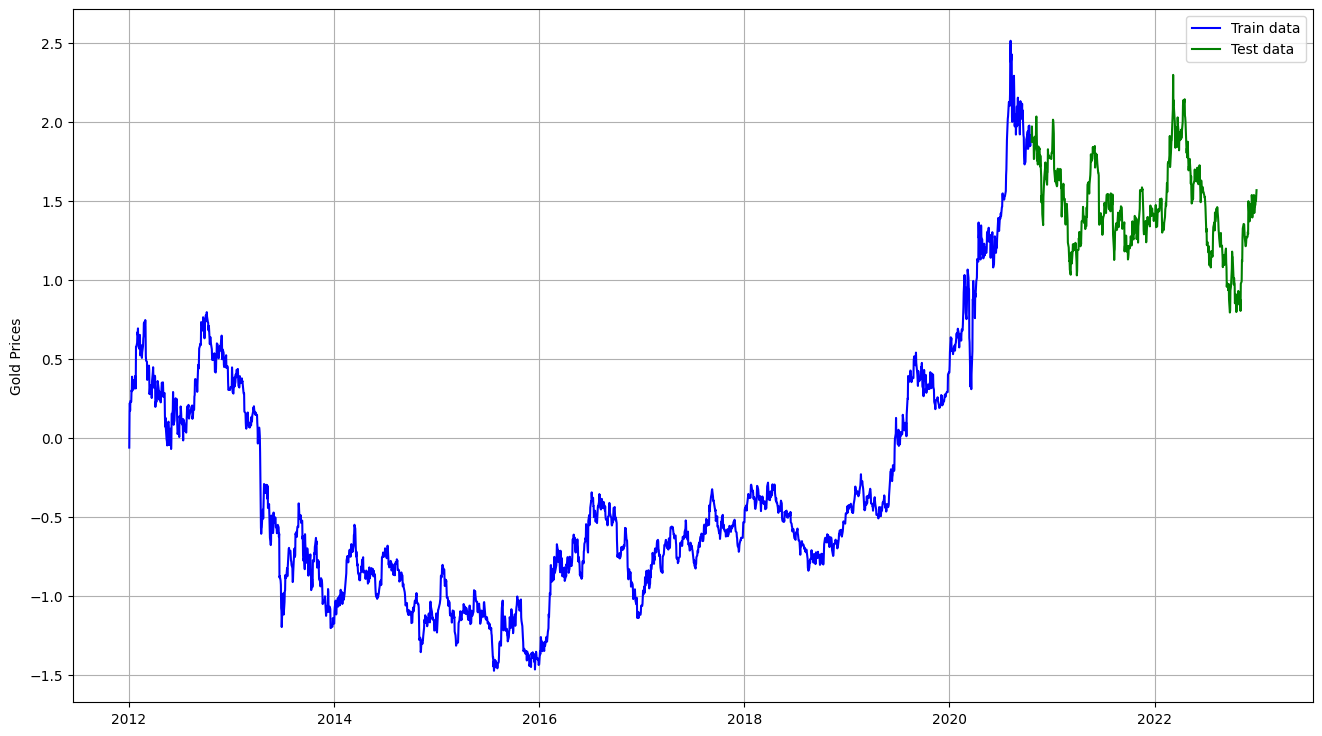

In [8]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.ylabel('Gold Prices')
plt.plot(train_data['VND'], 'blue', label='Train data')
plt.plot(test_data['VND'], 'green', label='Test data')
plt.legend()

#### Determine the independent variable (X) and the dependent variable (y).

In [9]:
X_train = train_data['Timestamp'].values.reshape(-1, 1)
y_train = train_data['VND'].values.reshape(-1, 1)

X_test = test_data['Timestamp'].values.reshape(-1, 1)
y_test = test_data['VND'].values.reshape(-1, 1)

#### The function that creates Hyperparameters 

In [10]:
def para_range(minimum, maximum, step):
    para_list = np.arange(minimum, maximum, step)
    return para_list


#### The function that outputs the results of each case in GridSearch

In [11]:
def print_stats(hyperparams, stats):
    if(hyperparams[0] == 'poly'):
        print(
            f'SVR(kernel={hyperparams[0]}, C={hyperparams[1]}, gamma={hyperparams[2]}, degree={hyperparams[3]}')
    else:
        print(
            f'SVR(kernel={hyperparams[0]}, C={hyperparams[1]}, gamma={hyperparams[2]}')

    print(
        f"MAE={stats[0]:.2f} | MAPE={stats[1]:.2f} | MSE={stats[2] :.2f} | RMSE={stats[3]:.2f}")


#### Generate values for the hyperparameters

In [12]:
kernels = ['sigmoid', 'rbf', 'poly']
Cs = para_range(0.01, 0.2, 0.1)
gammas = para_range(0.1, 5, 0.1)
degrees = para_range(1, 6, 1)


#### GridSearch to find suitable hyperparameters

In [13]:
warnings.filterwarnings('ignore')

stats_df = pd.DataFrame(
    columns=['kernel', 'C', 'gamma', 'degree', 'MAE', 'MAPE', 'MSE', 'RMSE'])

# GridSearch to find suitable hyperparameters
for ker in kernels:
    # If that is = = poly, make a choice degree.
    if(ker != 'poly'):
        for C in Cs:
            for gamma in gammas:
                rgs = SVR(kernel=ker, C=C, gamma=gamma, verbose=False)
                rgs.fit(X_train, y_train)
                pred = rgs.predict(X_test)

                # Transform back to original form
                inv_pred = y_sc.inverse_transform(
                    column_or_1d(pred).reshape(-1, 1))
                inv_test = y_sc.inverse_transform(
                    column_or_1d(y_test).reshape(-1, 1))
                    
                # Model Evaluation
                mae = mean_absolute_error(inv_test, inv_pred)
                mape = mean_absolute_percentage_error(inv_test, inv_pred)
                mse = mean_squared_error(inv_test, inv_pred)
                rmse = np.sqrt(mse)

                result = {'kernel': ker, 'C': C, 'gamma': gamma, 'degree': 0,
                          'MAE': mae, 'MAPE': mape, 'MSE': mse, 'RMSE': rmse}

                hyperparam = [ker, C, gamma, 0]
                stats = [mae, mape, mse, rmse]
                stats_df = stats_df.append(result, ignore_index=True)
                print_stats(hyperparam, stats)
    else:
        for C in Cs:
            for gamma in gammas:
                for deg in degrees:
                    rgs = SVR(kernel=ker, C=C, gamma=gamma, degree=deg, verbose=False)
                    rgs.fit(X_train, y_train.reshape(-1, 1))
                    pred = rgs.predict(X_test)

                    # Transform back to original form
                    inv_pred = y_sc.inverse_transform(
                        column_or_1d(pred).reshape(-1, 1))
                    inv_test = y_sc.inverse_transform(
                        column_or_1d(y_test).reshape(-1, 1))

                    # Model Evaluation
                    mae = mean_absolute_error(inv_test, inv_pred)
                    mape = mean_absolute_percentage_error(inv_test, inv_pred)
                    mse = mean_squared_error(inv_test, inv_pred)
                    rmse = np.sqrt(mse)

                    result = {'kernel': ker, 'C': C, 'gamma': gamma, 'degree': deg,
                            'MAE': mae, 'MAPE': mape, 'MSE': mse, 'RMSE': rmse}

                    hyperparam = [ker, C, gamma, deg]
                    stats = [mae, mape, mse, rmse]

                    stats_df = stats_df.append(result, ignore_index=True)

                    print_stats(hyperparam, stats)


SVR(kernel=sigmoid, C=0.01, gamma=0.1
MAE=10922499.72 | MAPE=0.26 | MSE=122416947982552.03 | RMSE=11064219.27
SVR(kernel=sigmoid, C=0.01, gamma=0.2
MAE=10314235.62 | MAPE=0.25 | MSE=109764984604553.89 | RMSE=10476878.57
SVR(kernel=sigmoid, C=0.01, gamma=0.30000000000000004
MAE=9652187.67 | MAPE=0.23 | MSE=97067000538800.72 | RMSE=9852258.65
SVR(kernel=sigmoid, C=0.01, gamma=0.4
MAE=8839981.61 | MAPE=0.21 | MSE=82933576845755.05 | RMSE=9106787.41
SVR(kernel=sigmoid, C=0.01, gamma=0.5
MAE=7820572.34 | MAPE=0.19 | MSE=67229296763613.83 | RMSE=8199347.34
SVR(kernel=sigmoid, C=0.01, gamma=0.6
MAE=6609433.65 | MAPE=0.16 | MSE=51261328898289.17 | RMSE=7159701.73
SVR(kernel=sigmoid, C=0.01, gamma=0.7000000000000001
MAE=5423933.79 | MAPE=0.13 | MSE=37585924836423.20 | RMSE=6130736.08
SVR(kernel=sigmoid, C=0.01, gamma=0.8
MAE=4367346.38 | MAPE=0.10 | MSE=26223241555084.60 | RMSE=5120863.36
SVR(kernel=sigmoid, C=0.01, gamma=0.9
MAE=3686145.24 | MAPE=0.09 | MSE=18892723635620.47 | RMSE=4346576.08


SVR(kernel=sigmoid, C=0.11, gamma=2.4000000000000004
MAE=158231491.21 | MAPE=3.83 | MSE=25943886916909704.00 | RMSE=161071061.70
SVR(kernel=sigmoid, C=0.11, gamma=2.5000000000000004
MAE=159049153.60 | MAPE=3.85 | MSE=26157294304574796.00 | RMSE=161732168.43
SVR(kernel=sigmoid, C=0.11, gamma=2.6
MAE=158885703.81 | MAPE=3.84 | MSE=26059962836106836.00 | RMSE=161430984.75
SVR(kernel=sigmoid, C=0.11, gamma=2.7
MAE=158546404.97 | MAPE=3.84 | MSE=25909848362617656.00 | RMSE=160965363.86
SVR(kernel=sigmoid, C=0.11, gamma=2.8000000000000003
MAE=157969031.88 | MAPE=3.82 | MSE=25686241625765440.00 | RMSE=160269278.48
SVR(kernel=sigmoid, C=0.11, gamma=2.9000000000000004
MAE=157544773.84 | MAPE=3.81 | MSE=25513120851879464.00 | RMSE=159728271.92
SVR(kernel=sigmoid, C=0.11, gamma=3.0000000000000004
MAE=157531682.57 | MAPE=3.81 | MSE=25473319473986896.00 | RMSE=159603632.40
SVR(kernel=sigmoid, C=0.11, gamma=3.1
MAE=157083946.26 | MAPE=3.80 | MSE=25299358900444448.00 | RMSE=159057721.91
SVR(kernel=si

SVR(kernel=rbf, C=0.01, gamma=4.8
MAE=6334004.72 | MAPE=0.15 | MSE=45876287173144.29 | RMSE=6773203.61
SVR(kernel=rbf, C=0.01, gamma=4.9
MAE=6389213.78 | MAPE=0.15 | MSE=46643314985045.16 | RMSE=6829591.13
SVR(kernel=rbf, C=0.11, gamma=0.1
MAE=2840015.42 | MAPE=0.07 | MSE=13247495567625.15 | RMSE=3639710.92
SVR(kernel=rbf, C=0.11, gamma=0.2
MAE=2442732.52 | MAPE=0.06 | MSE=9574122639768.04 | RMSE=3094207.92
SVR(kernel=rbf, C=0.11, gamma=0.30000000000000004
MAE=2378948.85 | MAPE=0.06 | MSE=9070773970477.87 | RMSE=3011772.56
SVR(kernel=rbf, C=0.11, gamma=0.4
MAE=3031226.41 | MAPE=0.07 | MSE=13962098953217.62 | RMSE=3736589.21
SVR(kernel=rbf, C=0.11, gamma=0.5
MAE=4362786.38 | MAPE=0.11 | MSE=26761131315131.76 | RMSE=5173116.21
SVR(kernel=rbf, C=0.11, gamma=0.6
MAE=5741286.29 | MAPE=0.14 | MSE=44064822738977.76 | RMSE=6638133.98
SVR(kernel=rbf, C=0.11, gamma=0.7000000000000001
MAE=6931105.93 | MAPE=0.17 | MSE=61493549134048.22 | RMSE=7841782.27
SVR(kernel=rbf, C=0.11, gamma=0.8
MAE=752740

SVR(kernel=poly, C=0.01, gamma=0.5, degree=4
MAE=9616487.88 | MAPE=0.23 | MSE=100642297689923.27 | RMSE=10032063.48
SVR(kernel=poly, C=0.01, gamma=0.5, degree=5
MAE=15833678.10 | MAPE=0.38 | MSE=255067536392344.41 | RMSE=15970833.93
SVR(kernel=poly, C=0.01, gamma=0.6, degree=1
MAE=10155301.45 | MAPE=0.24 | MSE=106376635544326.84 | RMSE=10313904.96
SVR(kernel=poly, C=0.01, gamma=0.6, degree=2
MAE=9117711.93 | MAPE=0.22 | MSE=88470774147195.95 | RMSE=9405890.40
SVR(kernel=poly, C=0.01, gamma=0.6, degree=3
MAE=15631901.45 | MAPE=0.38 | MSE=247289440848611.84 | RMSE=15725439.29
SVR(kernel=poly, C=0.01, gamma=0.6, degree=4
MAE=9561219.20 | MAPE=0.23 | MSE=99808477850187.70 | RMSE=9990419.30
SVR(kernel=poly, C=0.01, gamma=0.6, degree=5
MAE=15906665.20 | MAPE=0.38 | MSE=257483087368443.88 | RMSE=16046279.55
SVR(kernel=poly, C=0.01, gamma=0.7000000000000001, degree=1
MAE=10136352.13 | MAPE=0.24 | MSE=105996420887921.48 | RMSE=10295456.32
SVR(kernel=poly, C=0.01, gamma=0.7000000000000001, degre

SVR(kernel=poly, C=0.01, gamma=1.9000000000000001, degree=2
MAE=8916822.48 | MAPE=0.21 | MSE=85131465040424.55 | RMSE=9226671.40
SVR(kernel=poly, C=0.01, gamma=1.9000000000000001, degree=3
MAE=15848731.75 | MAPE=0.38 | MSE=254212098652723.41 | RMSE=15944030.19
SVR(kernel=poly, C=0.01, gamma=1.9000000000000001, degree=4
MAE=9508097.21 | MAPE=0.23 | MSE=99027618223461.48 | RMSE=9951262.14
SVR(kernel=poly, C=0.01, gamma=1.9000000000000001, degree=5
MAE=15955128.80 | MAPE=0.38 | MSE=259085842582044.66 | RMSE=16096143.72
SVR(kernel=poly, C=0.01, gamma=2.0, degree=1
MAE=9971420.78 | MAPE=0.24 | MSE=102718575060296.33 | RMSE=10135017.27
SVR(kernel=poly, C=0.01, gamma=2.0, degree=2
MAE=8915654.92 | MAPE=0.21 | MSE=85114425194848.59 | RMSE=9225747.95
SVR(kernel=poly, C=0.01, gamma=2.0, degree=3
MAE=15846369.12 | MAPE=0.38 | MSE=254137479595206.25 | RMSE=15941689.99
SVR(kernel=poly, C=0.01, gamma=2.0, degree=4
MAE=9508091.39 | MAPE=0.23 | MSE=99027523183280.08 | RMSE=9951257.37
SVR(kernel=poly, 

SVR(kernel=poly, C=0.01, gamma=3.2, degree=4
MAE=9508230.12 | MAPE=0.23 | MSE=99029789509551.59 | RMSE=9951371.24
SVR(kernel=poly, C=0.01, gamma=3.2, degree=5
MAE=15955576.73 | MAPE=0.38 | MSE=259100689940988.09 | RMSE=16096604.92
SVR(kernel=poly, C=0.01, gamma=3.3000000000000003, degree=1
MAE=9959174.06 | MAPE=0.24 | MSE=102476657260171.06 | RMSE=10123075.48
SVR(kernel=poly, C=0.01, gamma=3.3000000000000003, degree=2
MAE=8895618.91 | MAPE=0.21 | MSE=84781702953482.70 | RMSE=9207698.03
SVR(kernel=poly, C=0.01, gamma=3.3000000000000003, degree=3
MAE=15846365.40 | MAPE=0.38 | MSE=254137359329659.38 | RMSE=15941686.21
SVR(kernel=poly, C=0.01, gamma=3.3000000000000003, degree=4
MAE=9508079.98 | MAPE=0.23 | MSE=99020274907616.27 | RMSE=9950893.17
SVR(kernel=poly, C=0.01, gamma=3.3000000000000003, degree=5
MAE=15955984.02 | MAPE=0.38 | MSE=259114258995939.22 | RMSE=16097026.40
SVR(kernel=poly, C=0.01, gamma=3.4000000000000004, degree=1
MAE=9961000.62 | MAPE=0.24 | MSE=102512694951990.61 | RM

SVR(kernel=poly, C=0.01, gamma=4.6, degree=2
MAE=8894931.49 | MAPE=0.21 | MSE=84769473421033.89 | RMSE=9207033.91
SVR(kernel=poly, C=0.01, gamma=4.6, degree=3
MAE=15850331.53 | MAPE=0.38 | MSE=254265599192149.81 | RMSE=15945707.86
SVR(kernel=poly, C=0.01, gamma=4.6, degree=4
MAE=9507975.30 | MAPE=0.23 | MSE=99025626547552.58 | RMSE=9951162.07
SVR(kernel=poly, C=0.01, gamma=4.6, degree=5
MAE=15953518.14 | MAPE=0.38 | MSE=259032988226907.22 | RMSE=16094501.80
SVR(kernel=poly, C=0.01, gamma=4.7, degree=1
MAE=9892952.41 | MAPE=0.24 | MSE=101174366153904.67 | RMSE=10058546.92
SVR(kernel=poly, C=0.01, gamma=4.7, degree=2
MAE=8894927.53 | MAPE=0.21 | MSE=84769407142332.91 | RMSE=9207030.31
SVR(kernel=poly, C=0.01, gamma=4.7, degree=3
MAE=15852691.43 | MAPE=0.38 | MSE=254341028370135.47 | RMSE=15948072.87
SVR(kernel=poly, C=0.01, gamma=4.7, degree=4
MAE=9508097.55 | MAPE=0.23 | MSE=99027623873016.44 | RMSE=9951262.43
SVR(kernel=poly, C=0.01, gamma=4.7, degree=5
MAE=15960274.41 | MAPE=0.38 | MS

SVR(kernel=poly, C=0.11, gamma=1.1, degree=2
MAE=8894930.66 | MAPE=0.21 | MSE=84769459434142.86 | RMSE=9207033.15
SVR(kernel=poly, C=0.11, gamma=1.1, degree=3
MAE=15846358.68 | MAPE=0.38 | MSE=254137142438721.12 | RMSE=15941679.41
SVR(kernel=poly, C=0.11, gamma=1.1, degree=4
MAE=9508100.48 | MAPE=0.23 | MSE=99027671572585.78 | RMSE=9951264.82
SVR(kernel=poly, C=0.11, gamma=1.1, degree=5
MAE=15956021.99 | MAPE=0.38 | MSE=259115418701699.56 | RMSE=16097062.42
SVR(kernel=poly, C=0.11, gamma=1.2000000000000002, degree=1
MAE=9890316.25 | MAPE=0.24 | MSE=101122863463344.98 | RMSE=10055986.45
SVR(kernel=poly, C=0.11, gamma=1.2000000000000002, degree=2
MAE=8894927.98 | MAPE=0.21 | MSE=84769414692475.38 | RMSE=9207030.72
SVR(kernel=poly, C=0.11, gamma=1.2000000000000002, degree=3
MAE=15846370.16 | MAPE=0.38 | MSE=254137513246065.72 | RMSE=15941691.04
SVR(kernel=poly, C=0.11, gamma=1.2000000000000002, degree=4
MAE=9508103.60 | MAPE=0.23 | MSE=99027722569182.56 | RMSE=9951267.39
SVR(kernel=poly, 

SVR(kernel=poly, C=0.11, gamma=2.4000000000000004, degree=4
MAE=9508208.69 | MAPE=0.23 | MSE=99029439362589.88 | RMSE=9951353.64
SVR(kernel=poly, C=0.11, gamma=2.4000000000000004, degree=5
MAE=15954601.67 | MAPE=0.38 | MSE=259067447954596.12 | RMSE=16095572.31
SVR(kernel=poly, C=0.11, gamma=2.5000000000000004, degree=1
MAE=9882511.32 | MAPE=0.24 | MSE=100969540640188.44 | RMSE=10048360.10
SVR(kernel=poly, C=0.11, gamma=2.5000000000000004, degree=2
MAE=8878414.46 | MAPE=0.21 | MSE=84492993764863.53 | RMSE=9192007.06
SVR(kernel=poly, C=0.11, gamma=2.5000000000000004, degree=3
MAE=15853016.21 | MAPE=0.38 | MSE=254351415664502.62 | RMSE=15948398.53
SVR(kernel=poly, C=0.11, gamma=2.5000000000000004, degree=4
MAE=9507637.54 | MAPE=0.23 | MSE=99020109036630.53 | RMSE=9950884.84
SVR(kernel=poly, C=0.11, gamma=2.5000000000000004, degree=5
MAE=15959447.65 | MAPE=0.38 | MSE=259227539175546.31 | RMSE=16100544.69
SVR(kernel=poly, C=0.11, gamma=2.6, degree=1
MAE=9883473.83 | MAPE=0.24 | MSE=10098856

SVR(kernel=poly, C=0.11, gamma=3.8000000000000003, degree=2
MAE=8881591.19 | MAPE=0.21 | MSE=84546941433747.81 | RMSE=9194941.08
SVR(kernel=poly, C=0.11, gamma=3.8000000000000003, degree=3
MAE=15852855.89 | MAPE=0.38 | MSE=254346499755632.00 | RMSE=15948244.41
SVR(kernel=poly, C=0.11, gamma=3.8000000000000003, degree=4
MAE=9508240.13 | MAPE=0.23 | MSE=99029953313663.72 | RMSE=9951379.47
SVR(kernel=poly, C=0.11, gamma=3.8000000000000003, degree=5
MAE=15963877.86 | MAPE=0.38 | MSE=259376207056880.16 | RMSE=16105160.88
SVR(kernel=poly, C=0.11, gamma=3.9000000000000004, degree=1
MAE=9860823.50 | MAPE=0.24 | MSE=100545287358156.06 | RMSE=10027227.30
SVR(kernel=poly, C=0.11, gamma=3.9000000000000004, degree=2
MAE=8878447.35 | MAPE=0.21 | MSE=84493544071637.36 | RMSE=9192036.99
SVR(kernel=poly, C=0.11, gamma=3.9000000000000004, degree=3
MAE=15853223.93 | MAPE=0.38 | MSE=254358125004472.03 | RMSE=15948608.87
SVR(kernel=poly, C=0.11, gamma=3.9000000000000004, degree=4
MAE=9508759.48 | MAPE=0.23

#### Find the optimal parameters for the model

In [14]:
best_fit_model = stats_df[stats_df['MAPE'] == stats_df['MAPE'].min()].head(1)
best_fit_model


,kernel,C,gamma,degree,MAE,MAPE,MSE,RMSE
149,rbf,0.11,0.3,0,2.378949e+06,0.057968,9.070774e+12,3.011773e+06


#### Super vector regression - SVR

In [15]:
kernel = str(best_fit_model['kernel'].values[0])
C = float(best_fit_model['C'])
gamma = float(best_fit_model['gamma'])
degree = int(best_fit_model['degree'])

if(kernel == 'poly'):
    rgs = SVR(kernel=kernel, C=C, gamma=gamma, degree=degree)
else:
    rgs = SVR(kernel=kernel, C=C, gamma=gamma)
    
rgs.fit(X_train, y_train.reshape(-1, 1))
pred = rgs.predict(X_test)
pred

array([0.99833573, 0.99995038, 1.00156468, 1.00317862, 1.0080183 ,
       1.00963081, 1.01124295, 1.01285474, 1.01446615, 1.0192982 ,
       1.02090814, 1.02251771, 1.02412691, 1.02573573, 1.03055992,
       1.03216723, 1.03377415, 1.03538068, 1.03698683, 1.04180296,
       1.04340755, 1.04501175, 1.04661555, 1.04821896, 1.05302679,
       1.0546286 , 1.05623   , 1.057831  , 1.0594316 , 1.06423092,
       1.06582987, 1.06742841, 1.06902653, 1.07062424, 1.07541484,
       1.07701086, 1.07860646, 1.08020163, 1.08179638, 1.08657803,
       1.08817105, 1.08976364, 1.09135579, 1.09294751, 1.09772   ,
       1.09930995, 1.10089946, 1.10248851, 1.10407712, 1.10884025,
       1.11042705, 1.1120134 , 1.11359929, 1.11518472, 1.11993825,
       1.12152184, 1.12310496, 1.12468761, 1.1262698 , 1.13101353,
       1.13259383, 1.13417365, 1.13575299, 1.13733186, 1.14206557,
       1.1436425 , 1.14521895, 1.14679492, 1.14837039, 1.15309387,
       1.15466737, 1.15624038, 1.15781289, 1.1593849 , 1.16409

#### Transform back to original form

In [16]:
inv_pred = y_sc.inverse_transform(
    column_or_1d(pred).reshape(-1, 1))
inv_test = y_sc.inverse_transform(
    column_or_1d(y_test).reshape(-1, 1))

#### Graph the test set and the prediction results

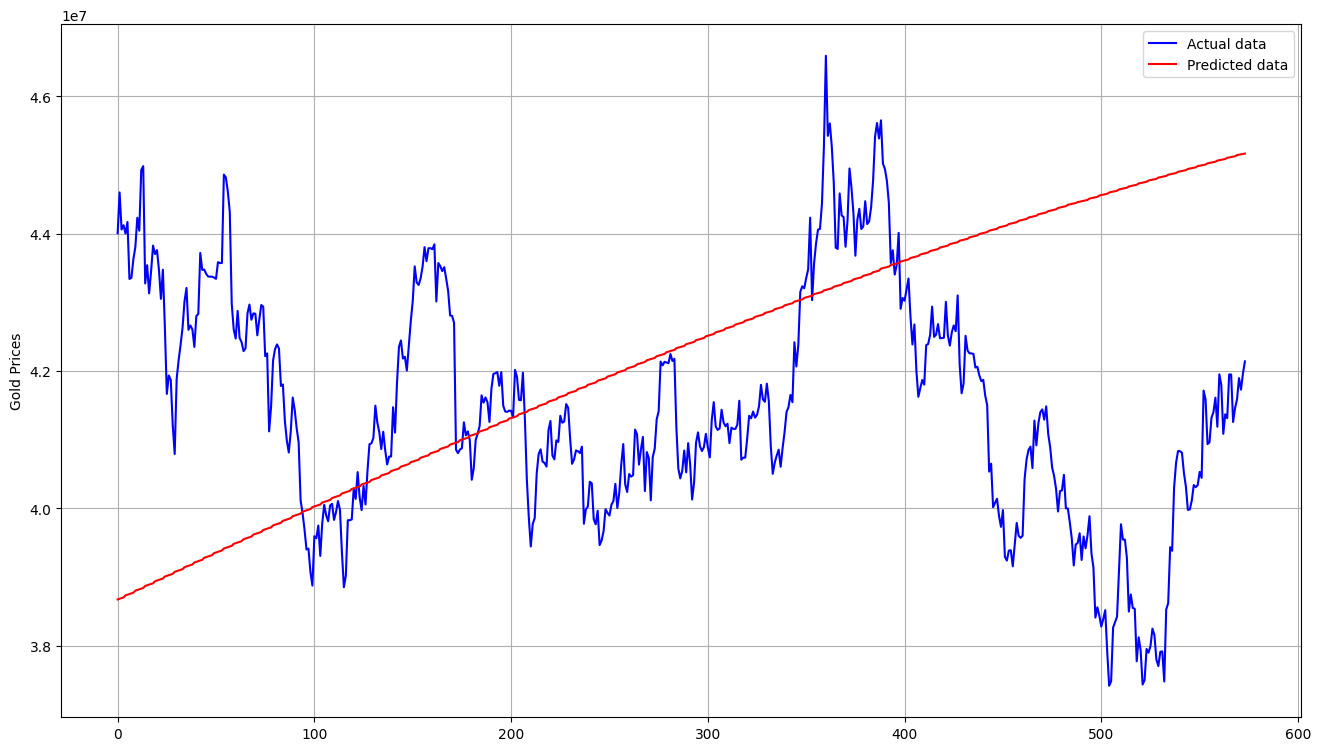

In [17]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.ylabel('Gold Prices')
plt.plot(column_or_1d(inv_test), 'blue', label='Actual data')
plt.plot(column_or_1d(inv_pred), 'red', label='Predicted data')
plt.legend()

#### Model Evaluation

In [18]:
from sklearn.metrics import r2_score
mae = mean_absolute_error(inv_test, inv_pred) 
mape = mean_absolute_percentage_error(inv_test, inv_pred)
mse = mean_squared_error(inv_test, inv_pred) 
rmse = np.sqrt(mse) 
r2 = r2_score(inv_test, inv_pred)
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 2378948.85
MAPE: 5.80%
MSE: 9070773970477.87
RMSE: 3011772.56
R2: -2.19
